In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler, normalize
from minisom import MiniSom

In [2]:
X = np.random.normal(loc=.25, scale=0.5, size=(500, 2))

<IPython.core.display.Javascript object>


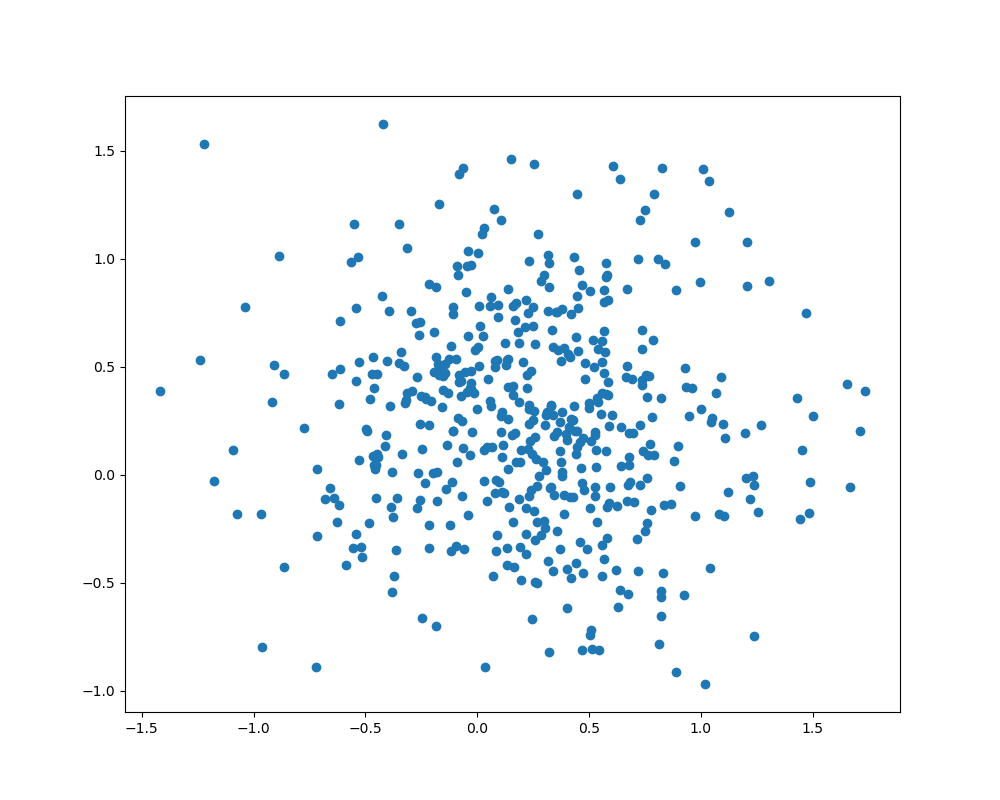

In [94]:
plt.figure(figsize=(10, 8), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(X[:,0],X[:, 1])

In [120]:
class KohonenNetwork:
    def __init__(self, n_clusters, eps=0.001, lr=0.1):
        self.n_clusters=n_clusters
        self.eps=eps
        self.weights=None
        self.scaler = StandardScaler()
        self.lr=lr
        
    def weights_have_stabilized(self, weights_current, weights_prev):
        return np.all(np.abs(weights_current-weights_prev)<self.eps)
    
    def fit(self, X):
        X=self.scaler.fit_transform(X)
        weights_current = np.random.rand(self.n_clusters, 2)
        while True:
            weights_prev = np.copy(weights_current)
            for x_i in X:
                winner_idx=self.get_winner(x_i, weights_current)
                self.correct_weights(winner_idx, x_i, weights_current)
            if self.weights_have_stabilized(weights_current, weights_prev): break
        self.weights = weights_current
        
    def get_winner(self, x_i, weights):
        y = np.dot(weights, x_i)
        k = np.argmax(y)
        return k
    
    def correct_weights(self, k, x_i, weights_current):
        weights_current[k] = self.scaler.fit_transform((weights_current[k] + self.lr * (x_i - weights_current[k])).reshape(1, 2))
        
    def predict(self, X):
        X = self.scaler.fit_transform(X)
        x_size = X.shape[0]
        clusters = np.zeros(x_size)
        for i in range(x_size):
            y = np.dot(self.weights, X[i])
            clusters[i] = np.argmax(y)
        return clusters

In [121]:
n_clusters = 4
kohonen_network = KohonenNetwork(n_clusters=n_clusters)
kohonen_network.fit(X)
y = kohonen_network.predict(X)

In [122]:
def plot_clusters(X, y, clusters_centers):
    n_clusters=clusters_centers.shape[0]
    plt.figure(figsize=(10, 10))
    for i in range(n_clusters):
        cluster_dots = X[np.where(y == i)[0], :]
        plt.scatter(cluster_dots[:, 0], cluster_dots[:, 1], marker='x', label=f"Cluster {i}")
        plt.scatter(clusters_centers[i, 0], clusters_centers[i, 1], s=70, label=f"Centroid for cluster {i}")
    plt.legend()
    plt.show()

<IPython.core.display.Javascript object>


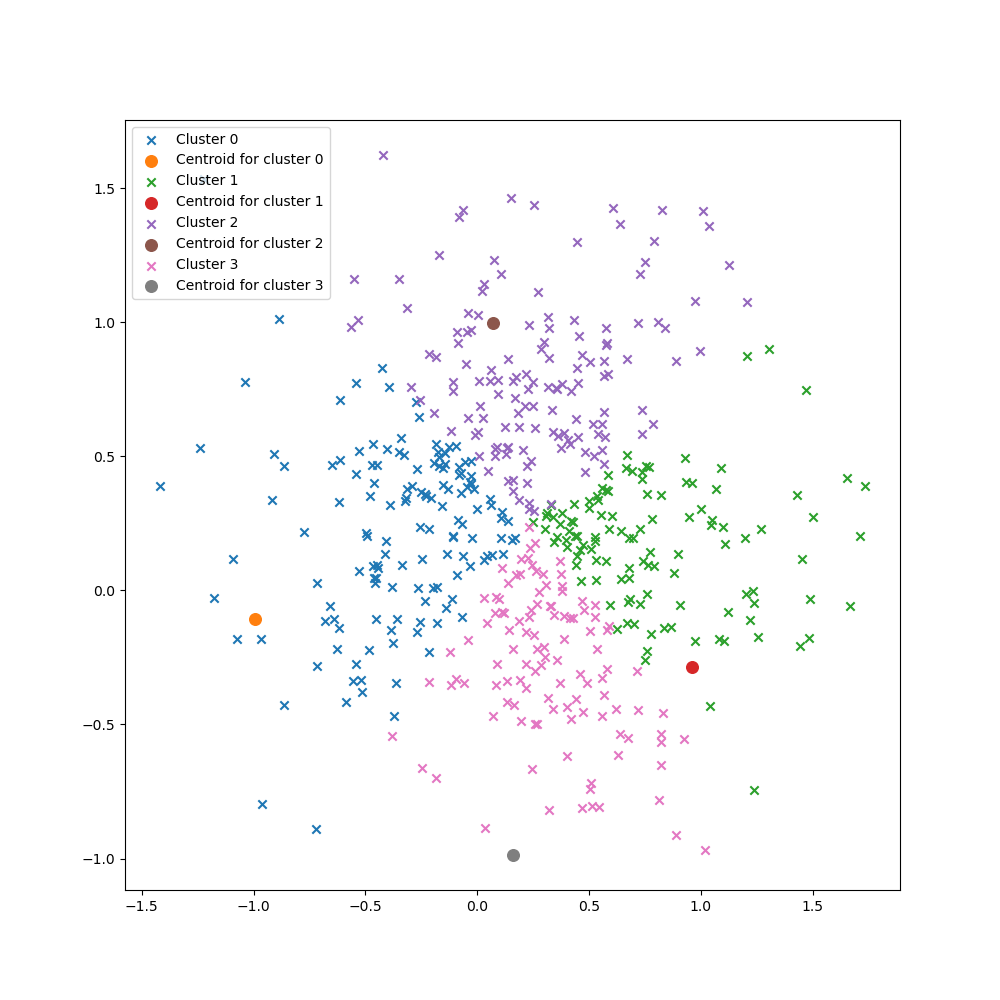

In [123]:
plot_clusters(X, y, kohonen_network.weights)

In [126]:
def euclidean_distance(x, y):
        return np.sqrt(np.sum((x - y)**2))
    
class SOM:    
    def __init__(self, shape, dist_f=euclidean_distance, eps=0.01, lr=0.01):
        self.shape = shape
        self.scaler = StandardScaler()
        self.weights=None
        self.lr=lr
        self.dist_f=dist_f
        self.eps=eps
        self._weights_current=None
        self._weights_prev=None
        self.n_nodes=np.prod(shape)

    def g(self, distance):
        return np.exp(-(distance ** 2))

    def correct_weight(self, node_idx, winner_idx, x_i):
        node_weight=self._weights_current[node_idx]
        distance=self.dist_f(self._weights_current[winner_idx], node_weight)
        self._weights_current[node_idx]=self.scaler.fit_transform((node_weight + self.lr * self.g(distance) * (x_i - node_weight)).reshape((1,2)))

    def fit(self, X):
        X=self.scaler.fit_transform(X)
        self._weights_current = np.random.rand(self.n_nodes, 2)
        iteration=0
        while True:
            self._weights_prev = np.copy(self._weights_current)
            for x_i in X:
                winner_idx=self.get_winner(x_i)
                self.correct_weight(winner_idx, winner_idx, x_i)
                neibors_idxes=self.get_neighbors(winner_idx)
                for neighbor in neibors_idxes:
                    neighbor_idx=self.from_cell_idx(neighbor)
                    self.correct_weight(neighbor_idx, winner_idx, x_i)
            if self.weights_have_stabilized():
                break
        self._weights_prev=None
        
    def get_neighbors(self, node_idx):
        def belong_to_grid(x_y):
            return x_y[0]>=0 and x_y[0]<self.shape[0] and x_y[1]>=0 and x_y[1]<self.shape[1]
        x_idx, y_idx=self.get_cell_idx(node_idx)
        neighbors_idxes=[
            (x_idx-1, y_idx),
            (x_idx+1, y_idx),
            (x_idx, y_idx-1),
            (x_idx, y_idx+1)
        ]
        return filter(belong_to_grid, neighbors_idxes)
        
    def get_winner(self, x_i):
        y = np.dot(self._weights_current, x_i)
        return np.argmax(y)
    
    def get_cell_idx(self, node_idx):
        return node_idx//self.shape[1], node_idx%self.shape[1]
    
    def from_cell_idx(self, cell_idx):
        return cell_idx[0]*self.shape[1]+cell_idx[1]
    
    def weights_have_stabilized(self):
        return np.all(np.abs(self._weights_current-self._weights_prev)<self.eps)

    def predict(self, X):
        X=self.scaler.fit_transform(X)
        n_predictions = X.shape[0]
        X_clusters = np.zeros(n_predictions)
        for i in range(n_predictions):
            X_clusters[i] = self.get_winner(X[i])
        return X_clusters

In [127]:
n_rows=3
n_cols=3
som = SOM(shape=(n_rows, n_cols))
som.fit(X)
y = som.predict(X)

<IPython.core.display.Javascript object>


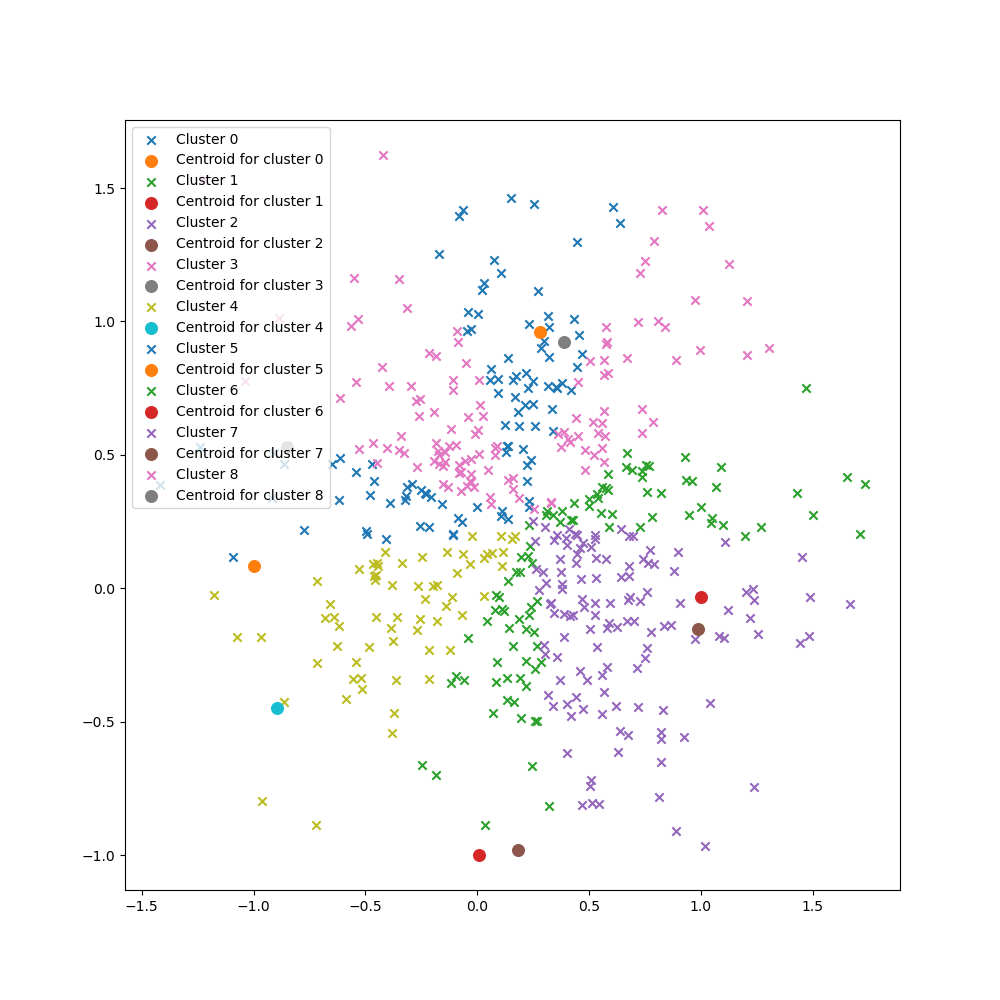

In [128]:
plot_clusters(X, y, som._weights_current.reshape((-1, 2)))

In [129]:
X_test = np.random.normal(loc=.25, scale=0.5, size=(100, 2))
y_test = som.predict(X_test)

<IPython.core.display.Javascript object>


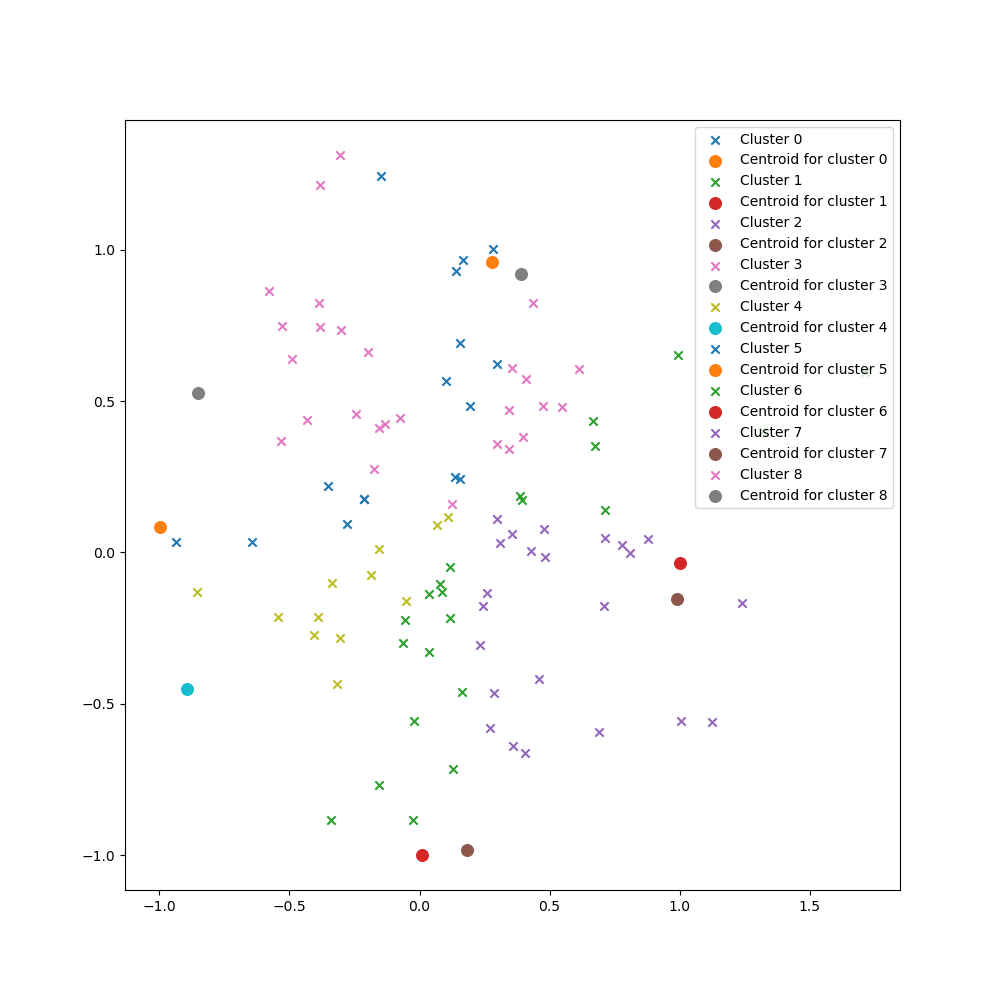

In [130]:
plot_clusters(X_test, y_test, som._weights_current.reshape((-1, 2)))